# Mini-Lab: Logistic Regression and SVMs

Antonio Debouse, Bodie Franklin, Eric Romero


More detailed explaination of attributes can be found at: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Resubmission Summary

<span style='background:yellow'> 
We are resubmitting the following sections:
    
</span>

* <a href ="#Summary"> Model Advantages  </a>

<span style='background:yellow'> 
Addressing the feedback provided:
</span>
    
* Missing Section
    * Added table of scoring metrics
    * Discussed advantages of each model

This lab consisted of building and comparing the effectiveness for different models used to predict whether a client would default on their credit card. The dataset is based on a Taiwanese credit card company.

### Table of Contents:

   * <a href="#BASE"> Base Logistic Regression Model </a>
   * <a href="#RFE"> Logistic Regression After RFE </a>
   * <a href="#HYPER"> Hypertuning Logistic Regression after RFE</a>
   * <a href="#FLRM"> Final Logistic Regression Model </a>
   * <a href ="#Summary"> Model Advantages  </a>
   * <a href="#WFLRM"> Interpretation of Weights of Final Logistic Regression Model </a>
   * <a href="#SVM"> Support Vector Machines </a>
   * <a href="#ISV"> Interpretation of Support Vectors    </a>
   * <a href ="#SVMSG"> SVM classifier with Stochastic descent </a>
   * <a href ="#WSVMSG"> Interpretation of Weights of SVM classifier with Stochastic descent </a>
  

## Import and Adjustment of Data

In [168]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('C:/Users/bodie/Documents/credit_card.csv')

#Deleting ID as useless variable

del df['ID']

#Dropping education variables 0,5,6 & Marriage status 0
#since we don't know what these are per UCI page and these are such a small portion of data less than 3%

df_new = df[(df.EDUCATION !=0)&(df.EDUCATION !=5) &
            (df.EDUCATION !=6) & (df.MARRIAGE!= 0)
           ]
#Sex, Education & Marriage are already int values, so need to transform them
df_new.info()
round(df.describe(),4)

#This is concerning that we have an imbalanced dataset
#We will need to address this imbalance by uppersampling.
print('---------------------------------------------')
print("default payment next month")
df_new['default_payment_next_month'].value_counts(normalize=True)

df_base = df_new


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29601 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     29601 non-null int64
SEX                           29601 non-null int64
EDUCATION                     29601 non-null int64
MARRIAGE                      29601 non-null int64
AGE                           29601 non-null int64
PAY_0                         29601 non-null int64
PAY_2                         29601 non-null int64
PAY_3                         29601 non-null int64
PAY_4                         29601 non-null int64
PAY_5                         29601 non-null int64
PAY_6                         29601 non-null int64
BILL_AMT1                     29601 non-null int64
BILL_AMT2                     29601 non-null int64
BILL_AMT3                     29601 non-null int64
BILL_AMT4                     29601 non-null int64
BILL_AMT5                     29601 non-null int64
BILL_AMT6                     29601 non-null int64
PAY_AMT1                

All categorical variables in the dataset were initially in integer format. Therefore, no encoding or transformation was needed.

Based on insight gained from Lab 1, we removed records that had values  not in the defined range of the data for categorical attributes of Education and Marriage.In example, Marriage had values of 0, but only values 1,2,3 were defined.  
  * We addressed  these ambiguous values in the data by deleting the records that contained them. The assumption is that   these records represented less than 2% of the dataset and were potentially mislabeled.Therefore the records could be removed with little effect on the overall data set.

## Balancing the data set

In [169]:
#Code utilized  from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
from collections import Counter

if 'default_payment_next_month' in df_new:
    y = df_new['default_payment_next_month'].values
    del df_new['default_payment_next_month']
    X = df_new.values

#Saving out the column names , so we can make dataframes later on 
col = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0',
       'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2',
       'BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2',
       'PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

os = SMOTE(random_state=99)


#Our new datasets to use will be X_res,y_res
#X_res is the resample dataset that is now more balance
#Y_res is the target column that is now more balance.

X_res, y_res = os.fit_resample(X, y)

#Previous class distribtion
counter = Counter(y)
print("Previous class breakdown:",counter)

# summarize the new class distribution
counter_res = Counter(y_res)
print("OS_breakout",counter_res)


Previous class breakdown: Counter({0: 22996, 1: 6605})
OS_breakout Counter({1: 22996, 0: 22996})


Our dataset was initially highly imbalanced toward non-defaulters which would make classifcations for our models difficult. To overcome this shortfall, we oversampled the minority class by utilizing the SMOTE technique from imblearn package. SMOTE works by creating synthetic copies of our minority class examples until there is an equal amount of them compared to the majority class examples. As seen above this was initially only 6605 defaults compared to 22996 non-defaults, using the technique raised the amount of default examples to the same count.Now the models will less favor  one class over the other and potentially produce higher prediction  metrics such as accuracy, sensitivity and specificity.

### Creating Seed and CV object

In [170]:
from sklearn.model_selection import ShuffleSplit
import random
#Setting Seed
#will use this in CV portion
random.seed(10)
seed = random.randint(1,500)
print("seed is:",seed)


#Setting up  the CV, code utlized from 04 Logits & SVM notebook
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         random_state = seed,
                         test_size  = 0.2)


print(cv_object)

seed is: 293
ShuffleSplit(n_splits=10, random_state=293, test_size=0.2, train_size=None)


In the above section, we are creating the CV object that we will use to test the metrics of each model. The seed is set is 293,
so all models will have the same seed for apples to apples comparison. We will use an 80/20 split for this lab.

<a id="BASE"></a>
# Baseline Logistic Regression Model

In [171]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
import imblearn
import numpy as np


#code utlized from 04 Logits & SVM notebook
#We are keeping paramters of LogisticRegression blank until we do paramter tuning
std_scl = StandardScaler()
lr_clf = LogisticRegression() 

# create the pipline
#code utlized from 04 Logits & SVM notebook
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

#code utlized from 04 Logits & SVM notebook
#We trained our model(including all variables at the moment) on 10 CV with random state set to the seed variable
#We are looping through and calcing ACC,Spec and Sensitivty.
#This section utliztied code from unit 4 notebook &
#https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/

Iteration = []
Accuracy = []
Sensitivity = []
Specificity = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_res,y_res)):
    piped_object.fit(X_res[train_indices],y_res[train_indices])  # train object
    y_hat = piped_object.predict(X_res[test_indices]) # get test set precitions
    
    cm1 = mt.confusion_matrix(y_res[test_indices],y_hat)
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y_res[test_indices],y_hat))
    Sensitivity.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    
lr_base_results = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Sensitivity':Sensitivity,
                                'Specificity':Specificity},columns = ['Iteration','Accuracy','Sensitivity','Specificity'])


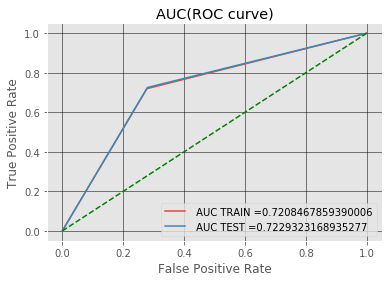

,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.726275,0.734317,0.718206
1,1,0.722796,0.721170,0.724456
2,2,0.720513,0.726004,0.714883
3,3,0.721274,0.725796,0.716718
4,4,0.721274,0.720818,0.721720
5,5,0.727144,0.732942,0.721340
6,6,0.725840,0.728280,0.723395
7,7,0.719100,0.725508,0.712878
8,8,0.721600,0.724517,0.718743
9,9,0.721709,0.724537,0.718899


In [191]:
#Utilized code from https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20)

lr_clf = LogisticRegression() 

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


piped_object.fit(X_train,y_train)

y_train_pred =piped_object.predict(X_train)    
y_test_pred = piped_object.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()
(lr_base_results)

### Baseline Model Results
Our first task was to build a base logistic regression model  included all of the features within the dataset. This was done to gain a sense of how the predictions performed and then  use as a baseline comparsion score for our other models. The baseline
model over 10 iterations performed a 72% average for accuracy, sensitivity, and specificity. Examining the ROC curve, we can assess our models' true-positive to false-positive tradeoff relationship.  The AUC for both the training and test set is basically identical at about 72%, which gives us confidence that our prediction model will preform well on other similar datasets.The base logisitic regression model had no parameters associated with it.As it is not practical to include all the features, we will continue on to alternative models that eliminate some features in favor of a higher scoring metric.


## Recursive Feature Elimination (RFE)

In [173]:
%%time
#For building our logic model, we used RFE
# we utlized code from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

#Since our model has a bunch of coffeicnets , we're going to use RFE in order to figure out which variables to elimate from our
#model. once we near our list, then we will have completed building a logistic regression model!

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


std_scl = StandardScaler()
lr_clf = LogisticRegression() 
rfe = RFE(lr_clf, n_features_to_select=10)

# create the pipline
#code utlized from 04 Logits & SVM notebook
piped_object_RFE = Pipeline([('scale', std_scl),  
                             ('RFE',rfe)]) 
 



#rfe = rfe.fit(X_res, y_res.ravel())

RFE_RESULTS = piped_object_RFE.fit(X_res,y_res.ravel())

print(rfe.support_)
print(rfe.ranking_)
#This gives us the column names from RFE feature selection.
df_new.columns[rfe.support_]

[ True  True  True  True False  True False False False  True False  True
  True False False False False  True  True False False False False]
[ 1  1  1  1  4  1  2  8 10  1 14  1  1  9 13 12  6  1  1  3  7  5 11]
Wall time: 1.14 s


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_5',
       'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2'],
      dtype='object')

### RFE Feature Analysis
RFE works by first including all the features or attributes in the initial model. Next the weakest features relating to our predicted category are removed one by one until a specific amount of features is reached. This process particularly targets elimination of any dependencies and collinearity between attributes that would make our predictions more difficult. The amount of features kept is determined by cross validation with RFE to score each of the features and select which ones give the best values for prediction.

Based on running the RFE model, features were eliminated down to 10 attributes as seen in the above index. Specifically most attributes removed were related to bill and payment amounts, those that were kept in the model were around the beginning and end of the records. This matches with our analysis from Lab 1 that showed these attributes were more correlated over any other. Attributes such as sex, education, and marriage were also identified to be included in the model which we also saw from our Lab 1 analysis displayed some small relationships with the default category.

### Filtering dataset after RFE analysis

In [174]:
#The above True/False line up with the columns
#'SEX','EDUCATION','EDUCATION','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1'
#So we need to reorg the dataframe X_res then continue with the process

X_rs = pd.DataFrame(data=X_res,columns=col)

imp_col = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_5',
       'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2']

X_rs  = X_rs[imp_col]

y_rs = pd.DataFrame(data=y_res,columns=['default_payment_next_month'])

#Checking the heads to make sure it worked
X_rs.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_5,BILL_AMT1,BILL_AMT2,PAY_AMT1,PAY_AMT2
0,20000,2,2,1,2,-2,3913,3102,0,689
1,120000,2,2,2,-1,0,2682,1725,0,1000
2,90000,2,2,2,0,0,29239,14027,1518,1500
3,50000,2,2,1,0,0,46990,48233,2000,2019
4,50000,1,2,1,-1,0,8617,5670,2000,36681


In the code section above, we are filtering the dataset to only include the features that RFE deemed appropriate. The head is printed
just to check that the filtering was successful. 

<a id="RFE"></a>
# Logistic Regression After RFE

In [175]:

X_rs = X_rs.values
y_rs = y_rs['default_payment_next_month'].values



Iteration_fbase = []
Accuracy_fbase = []
Sensitivity_fbase = []
Specificity_fbase = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_rs,y_rs)):
    piped_object.fit(X_rs[train_indices],y_rs[train_indices])  
    y_hat = piped_object.predict(X_rs[test_indices]) 
    
    cm1 = mt.confusion_matrix(y_rs[test_indices],y_hat)
    
    Iteration_fbase.append(iter_num)
    Accuracy_fbase.append(mt.accuracy_score(y_rs[test_indices],y_hat))
    Sensitivity_fbase.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity_fbase.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    
final_base_results = pd.DataFrame({'Iteration':Iteration_fbase,'Accuracy': Accuracy_fbase,'Sensitivity':Sensitivity_fbase,
                                'Specificity':Specificity_fbase},columns = ['Iteration','Accuracy','Sensitivity','Specificity'])





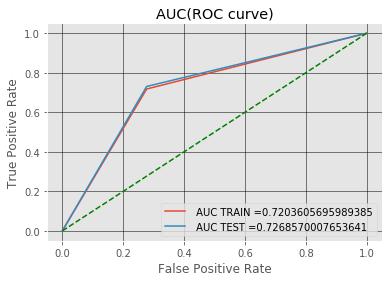

,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.728775,0.736922,0.720601
1,1,0.722470,0.718158,0.726873
2,2,0.721818,0.726004,0.717525
3,3,0.719643,0.726013,0.713226
4,4,0.718665,0.717520,0.719785
5,5,0.724427,0.731204,0.717642
6,6,0.725188,0.728497,0.721872
7,7,0.719100,0.728376,0.710092
8,8,0.720622,0.722979,0.718313
9,9,0.720948,0.726936,0.714998


In [193]:
#Utilized code from https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)

lr_clf = LogisticRegression() 

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


piped_object.fit(X_train,y_train)

y_train_pred =piped_object.predict(X_train)    
y_test_pred = piped_object.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()


final_base_results

### Results of Model after RFE Analysis
The results of 10 CV for our logistic regression model after using RFE, shown above, resulted in a consistent 72% average for accuracy, sensitivity, and specificity.In comparison to our base logistic regression model these are nearly the same outcomes, with some small differences such as specificity. Specificity seems to be slightly lower here. This result potentially fits with our initial assumptions from Lab 1; attributes such as payments or bill amounts recorded between period 3 to period 4 have little impact on the predicting defaults. Overall scoring metrics were not significantly impacted, removing those attributes improved the run time of the model since less features were used. Examining the ROC curve, we can assess our models' true-positive to false-positive tradeoff relationship.  The AUC for both the training and test set is basically identical at about 72%, which gives us confidence that our prediction model will preform well on other similar datasets.


## Hyperparameter Tuning Logistic Regression model

In [183]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)



#found parameters from document
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

lr_param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'C': [.001,.01,.1,1,10,100],'class_weight':['dict','balanced','none'],
              'solver':[ 'newton-cg', 'lbfgs', 'liblinear', 'sag','saga']
             }


#We set error score to 0 to avoid warnings messages for NaN due 
#to Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty

grid = GridSearchCV(LogisticRegression(),param_grid=lr_param_grid,cv=10,scoring='accuracy',refit=True,verbose=2,
                   n_jobs=-1,error_score=0)


piped_object_lr_pt = Pipeline([('scale', std_scl),  
                         ('gridsearch', grid)])


piped_object_lr_pt.fit(X_train,y_train)


print(grid.best_estimator_)
print("------------------------------------------------------------------------")
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results.iloc[grid.best_index_])
print("------------------------------------------------------------------------")
print(grid.best_params_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
------------------------------------------------------------------------
mean_fit_time                                                  0.455189
std_fit_time                                                  0.0358175
mean_score_time                                              0.00109026
std_score_time                                              0.000301957
param_C                                                               1
param_class_weight                                             balanced
param_penalty                                                        l1
param_solver                                                  liblinear
params                {'C': 1, 'class_weight': 'balanced', 'penalty'...
split0_test_score                                              0.718207
split1_test_score                       

### Parameter Tuning
Hyper parameter tuning allows us to attempt to increase the accuracy of our model at the expense of potentially overfitting our data. To find values to use for the hyperparameters we used a grid search. Optimizations was done through parameter penalties, inverse regularization strength (C), class weights and solvers selected from the list generated by the above code. Our parameter tuning results suggest that the best paramters for our model is :
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

 <a id="FLRM"></a>
  
# Final Logistic Regression Model

In [184]:
from sklearn import metrics

lr_clf = LogisticRegression(C=.01,class_weight='balanced',penalty='l1',solver='liblinear') 

# create the pipline
#code utlized from 04 Logits & SVM notebook
piped_object_lr = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

Iteration_lrbase = []
Accuracy_lrbase = []
Sensitivity_lrbase = []
Specificity_lrbase = []


weights_lr_final = []
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_rs,y_rs)):
    piped_object_lr.fit(X_rs[train_indices],y_rs[train_indices])  
    weights_lr_final.append(piped_object_lr.named_steps['logit_model'].coef_[0])
    y_hat = piped_object_lr.predict(X_rs[test_indices]) 
    
    cm1 = mt.confusion_matrix(y_rs[test_indices],y_hat)
    
    Iteration_lrbase.append(iter_num)
    Accuracy_lrbase.append(mt.accuracy_score(y_rs[test_indices],y_hat))
    Sensitivity_lrbase.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity_lrbase.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    

final_lr_results= pd.DataFrame({'Iteration':Iteration_lrbase,'Accuracy': Accuracy_lrbase,
                            'Sensitivity':Sensitivity_lrbase,'Specificity':Specificity_lrbase},
                            columns = ['Iteration','Accuracy','Sensitivity','Specificity'])





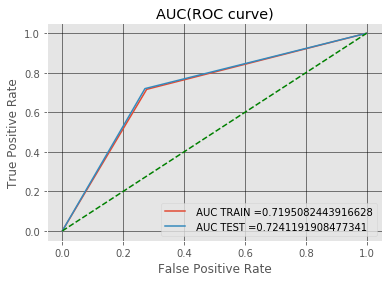

,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.728666,0.736705,0.720601
1,1,0.722687,0.723107,0.722259
2,2,0.721383,0.727078,0.715544
3,3,0.719535,0.728178,0.710825
4,4,0.716926,0.712025,0.721720
5,5,0.721165,0.727075,0.715249
6,6,0.722796,0.724153,0.721436
7,7,0.718013,0.721536,0.714592
8,8,0.719535,0.720343,0.718743
9,9,0.719643,0.722792,0.716515


In [194]:
#Utilized code from https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


lr_clf = LogisticRegression(C=.01,class_weight='balanced',penalty='l1',solver='liblinear') 

piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


piped_object.fit(X_train,y_train)

y_train_pred =piped_object.predict(X_train)    
y_test_pred = piped_object.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



(final_lr_results)

The results of 10 CV for our logistic regression model after using RFE and parameter tunig , shown above, resulted in a consistent 72% average for accuracy, sensitivity, and specificity. These results are similiar to our base logistric regression model and our logistric regression model after RFE. Therefore there is no gain in scoring metrics.The final logistic regression model has less features ,therefore would be prefered over the base since it is the less complicated model.Examining the ROC curve, we can assess our models' true-positive to false-positive tradeoff relationship. The AUC for both the training and test set is basically identical at about 72%, which gives us confidence that our prediction model will preform well on other similar datasets.

<a id="Summary"></a>

# Model Advantages


In [3]:
import pandas as pd
Scores = pd.DataFrame(
{'Model': ['Logistic Regression', 'SVM classifier with Stochastic descent:', 'SVM:'],
'Accuracy': ['0.7210349', '0.7206762', '0.7550712'],
 'Sensitivity' : ['0.7242992','0.7265025','0.7829354'],
 'Specificity': ['0.7177484','0.7148734','0.7272497'],
 'Time': ['689 ms','252 ms','3min 17s'] })
                
Scores

,Model,Accuracy,Sensitivity,Specificity,Time
0,Logistic Regression,0.7210349,0.7242992,0.7177484,689 ms
1,SVM classifier with Stochastic descent:,0.7206762,0.7265025,0.7148734,252 ms
2,SVM:,0.7550712,0.7829354,0.7272497,3min 17s


<span style='background:yellow'> 
The table above shows the average score metrics over 10 CV for each respective model.  Based on the scores, the model with the highest performance metrics was the SVM. The SVM reported nearly .03 higher in an accuracy score compared to Logistic Regression and SVM classifier with Stochastic descent. In addition, SVM’s Sensitivity was .05 higher than the other models.  The only trade off with SVM was that it required over an hour to tune the parameters utilizing gridsearch and over 3 mins to validate 10 CV. Therefore, we believe if SVM was given more data the run time would increase exponentially. <br> <br>
The Logistic regression and SVM classifier with Stochastic descent reported nearly identical performance metrics for Accuracy, Sensitivity and Specificity.  SVM classifier with Stochastic descent had a slightly lower run time for validation (252 ms vs 689 ms).  Another advantage of the SVM classifier with Stochastic descent model is that it required no tuning.   The logistic regression reported nearly identical scoring metrics as SVM classifier with Stochastic descent. Therefore its only advantage was that it required less setup time compared to the SVM model. For example, it only took 689 ms run time for 10 CV and took nearly 2 minutes to complete the tuning with grid search parameters. 
</span>

<a id="WFLRM"></a>
# Interpretation of Weights for Final Logistric Regression Model

,Variable,Weight
4,PAY_0,0.665019
7,BILL_AMT2,0.335201
5,PAY_5,0.201610
9,PAY_AMT2,-0.212916
0,LIMIT_BAL,-0.249983
8,PAY_AMT1,-0.302664
1,SEX,-0.371896
2,EDUCATION,-0.394770
6,BILL_AMT1,-0.406567
3,MARRIAGE,-0.526205


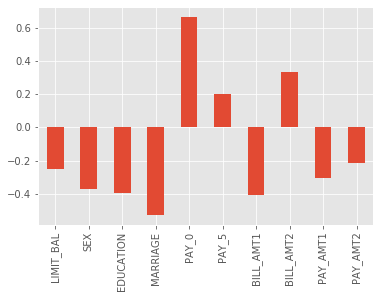

Wall time: 267 ms


In [187]:
%%time
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size=0.2, random_state=seed)

lr_clf = LogisticRegression(C=.01,class_weight='dict',penalty='l2',solver='newton-cg') 

piped_object_lr = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)])
piped_object_lr.fit(X_train,y_train)

weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = imp_col

Final_LR_weights =pd.DataFrame({'Variable':variable_names,'Weight': weights.ravel()},columns=['Variable','Weight'])
Final_LR_weights.sort_values(by="Weight",inplace=True,ascending=False)


display(Final_LR_weights)


graph_weights = pd.Series(lr_clf.coef_[0],index=variable_names)
graph_weights.plot(kind='bar')
plt.show()


Examining the weights of attributes included in the tuned LR model we see that Pay_0 displayed the highest positive weight which meets our original analysis from Lab 1 as a heavy contributor for classifying the default class. Our Lab 1 showed a distinct separation  between defaults and non-defaults for pay_0. A negative value for Pay_0 indicated that the borrower prepaid, therefore the risk of the borrower defaulting was reduced. A positive value for Pay_0 indicated that the borrower deferred their payment,thus increasing the likelihood of default. Based on this, it makes sense that Pay_0 has the highest absolute weight of our LR model.     

The Education feature has a negative weight of -.39 indicating that this feature reduces your chance of defaulting. Our Lab 1 analysis showed that education levels 1 & 2 had the highest rates of default despite representing the highest levels of education. We theorized that borrowers with the highest level are unable to make payments due to large student debts. If a borrower had education level of 4, the borrower's overall chance of defaulting would be reduced. 

Marriage carried a significant negative weight which indicates that if a borrower was married/other, the borrower was less likely to default on their payment. Perhaps this is due dual income house.

Sex carried a significant negative weight as well. Sex indicates that a female(value of 2) is more likely to default than a male. We theorized that this is due to student debt as well. Our data shows that females are more likey to be in the highest education levels 1 & 2. Therefore, it is possible that these individuals may carry larger amounts of student debt and  may increase the challenges of servicing other debts.  

It is interesting that Bill_AMT1 & Bill_AMT2 has inverse weights. We theorized that the this is due to the timing of the billing cycle relative to when default is declared. For example, a borrower could have a lower bill 1 amount due but their outstanding credit debt is large. When the outstanding debt becomes due in bill two, we see that the risk of the credit borrower increases. As it becomes more difficult to make large payments.


However, we would need to gain a much more in-depth understanding of the Taiwanese cultures and systems before making any further assumptions with conviction.


<a id="SVM"></a>
# Support Vector Machines (SVM)

In [153]:
%%time

#https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)

#Due to computing power limitations, i removed poly from kernel input and only ran 5 CV for parameters.
param_grid = {'C': [0.1,1, 10], 'gamma': [.001,.01,.1,1],'kernel': ['rbf', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
piped_object_grid = Pipeline([('scale', std_scl),  
                         ('svm', grid)])


piped_object_grid.fit(X_train,y_train)


print(grid.best_estimator_)
print("------------------------------------------------------------------------")
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results.iloc[grid.best_index_])
print("------------------------------------------------------------------------")
print(grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  45.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  45.8s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  45.4s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  46.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  47.6s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  40.9s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  39.8s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  39.9s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  39.6s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=  39.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  40.4s
[CV] END ......................C=0.1, gamma=0.0

In the code above, we attempted to find the best parameters for our SVM model. Unfortantely due to computing power, we were only able to run a 5 CV with the parameters above. Poly was not included in the parameter testing because every CV took nearly 5 mins a piece and would have significantly increase the run time.  The run time above took nearly an hour and half. It would not have been feasible to perform a 10 CV. 

Based on the output from our CV results, the best parameters are "{'C': 1, 'gamma': 1, 'kernel': 'rbf'}" which is used to create the SVM model in the following code:

# SVM final model

In [189]:
%%time

param_grid = {'C': [1], 'gamma': [1],'kernel': ['rbf']}

from sklearn.svm import SVC

svm_clf = SVC(C=1, kernel='rbf', gamma=1)



piped_object_svc = Pipeline([('scale', std_scl),  # do this
                         ('svm', svm_clf)]) # and then do this


Iteration_svm = []
Accuracy_svm = []
Sensitivity_svm = []
Specificity_svm = []



for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_rs,y_rs)):
    piped_object_svc.fit(X_rs[train_indices],y_rs[train_indices])  # train object
    y_hat = piped_object_svc.predict(X_rs[test_indices])
    
    cm1 = mt.confusion_matrix(y_rs[test_indices],y_hat)
    
   
    Iteration_svm.append(iter_num)
    Accuracy_svm.append(mt.accuracy_score(y_rs[test_indices],y_hat))
    Sensitivity_svm.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity_svm.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    

final_svm_results= pd.DataFrame({'Iteration':Iteration_svm,'Accuracy': Accuracy_svm,
                            'Sensitivity':Sensitivity_svm,'Specificity':Specificity_svm},
                            columns = ['Iteration','Accuracy','Sensitivity','Specificity'])



Wall time: 16min 3s


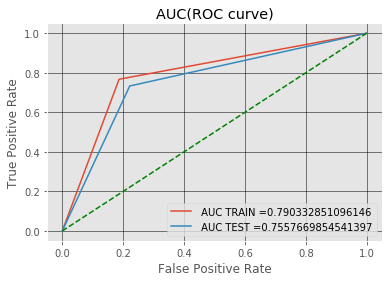

Wall time: 3min 17s


,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.757256,0.782071,0.732361
1,1,0.760083,0.783993,0.735662
2,2,0.754104,0.787632,0.719727
3,3,0.752799,0.784276,0.721082
4,4,0.756278,0.784568,0.728602
5,5,0.761605,0.790309,0.732869
6,6,0.754212,0.780626,0.727748
7,7,0.751277,0.782657,0.720806
8,8,0.748668,0.773506,0.724338
9,9,0.754430,0.779716,0.729302


In [195]:
%%time
#Utilized code from https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

svm_clf = SVC(C=1, kernel='rbf', gamma=1)

piped_object_svc = Pipeline([('scale', std_scl),  # do this
                         ('svm', svm_clf)])

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


piped_object_svc.fit(X_train,y_train)

y_train_pred =piped_object_svc.predict(X_train)    
y_test_pred = piped_object_svc.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()


final_svm_results

### SVM Results Analysis
For the SVM model shown above we see an average of approximately 75% for accuracy, a 3% improvement over our base model. Sensitivity averaged at 78% which is a 5% increase over base, while specificity remained similar to our base model results at approximately 72%. Examining the ROC curve, we can assess our models' true-positive to false-positive tradeoff relationship.  The AUC for the training and test is 79% & 75% respectively, which gives us confidence that our prediction model will preform well on other similar datasets.This performance differs slightly from our previous models due to how SVM uses information  from the edges of the class boundaries.

Running the SVM model takes a somewhat larger amount of time at about 20 minutes as seen above using the "rbf" kernal. In order to also look at reduce computing time as much as possible we will also comparatively use a stochastic descent classifier on the SVM model.

<a id="ISV"></a>
# Interpretation of Support Vectors 

### Finding the Support Vectors

In [71]:
%%time


for train_indices, test_indices in cv_object.split(X_rs,y_rs): 
    
    X_train = X_rs[train_indices]
    y_train = y_rs[train_indices]
    
    X_test = X_rs[test_indices]
    y_test = y_rs[test_indices]
    

X_train_scaled = std_scl.transform(X_train) 
X_test_scaled = std_scl.transform(X_test) 

svm_clf = SVC(C=1, kernel='rbf', gamma=1)

svm_clf.fit(X_train_scaled,y_train)

y_hat =svm_clf.predict(X_test_scaled)

print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(22124, 10)
(22124,)
[11588 10536]
Wall time: 1min 38s


 SVM selected 22,124 records from our training set as the support vectors.

In [77]:
df_tested_on = X_rs[train_indices].copy()
df_support = df_tested_on[svm_clf.support_,:]
df_support = pd.DataFrame(df_support,columns=imp_col)
df_support['default_payment_next_month'] = y_rs[svm_clf.support_]
df_support.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22124 entries, 0 to 22123
Data columns (total 11 columns):
LIMIT_BAL                     22124 non-null int64
SEX                           22124 non-null int64
EDUCATION                     22124 non-null int64
MARRIAGE                      22124 non-null int64
PAY_0                         22124 non-null int64
PAY_5                         22124 non-null int64
BILL_AMT1                     22124 non-null int64
BILL_AMT2                     22124 non-null int64
PAY_AMT1                      22124 non-null int64
PAY_AMT2                      22124 non-null int64
default_payment_next_month    22124 non-null int64
dtypes: int64(11)
memory usage: 1.9 MB


In code section above, we are creating the dataframes needed to graph the SVM.

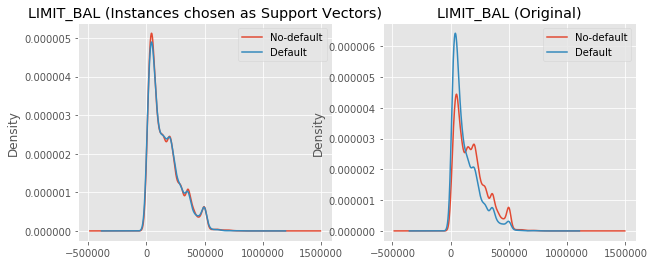

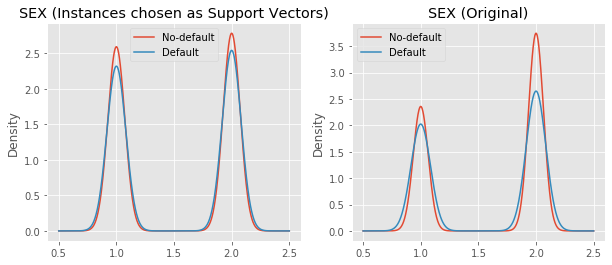

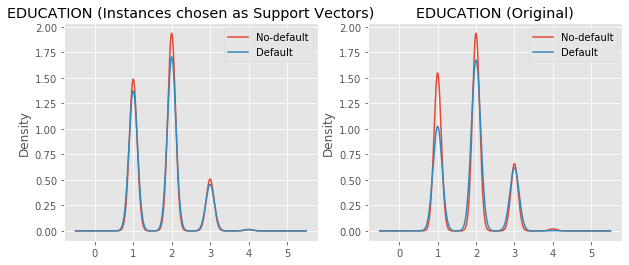

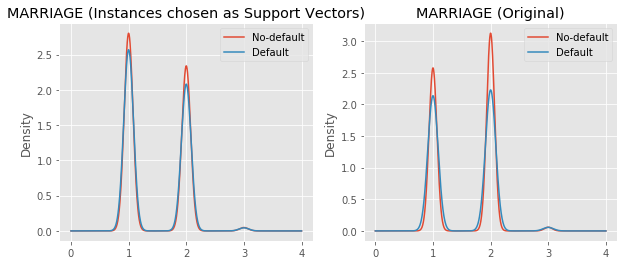

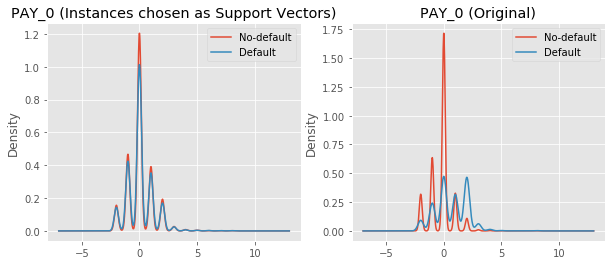

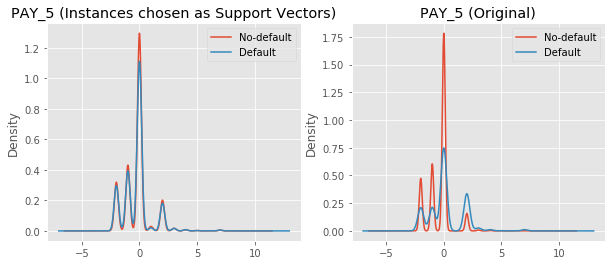

In [85]:
%%time
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['default_payment_next_month'])
df_grouped = df_base.groupby(['default_payment_next_month'])

# plot KDE of Different variables
vars_to_plot = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','PAY_0','PAY_5']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No-default','Default'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No-default','Default'])
    plt.title(v+' (Original)')


Graphics on the right side (original) display the separations between classifications found in our original dataset previously analyzed in Lab 1. Support vector plots display a better fit, however this is mostly due to the information being used from the edges of the class boundaries which results in some integrity loss of the original data. Some of these losses can be seen in comparison between graphs such as in the sex attribute where the peaks clearly change densities for value 2 (females). Also some smoothing in curvature can be seen such as in limit balance which will decrease some of the data integrity as well, however most of the data is preserved in the support vector plots


<a id="SVMSG"></a>
# SVM classifier with Stochastic descent

In [165]:
%%time
#Utilized code from unit 4 notebook
#reating a linear SVM classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
regularize_const = 0.1
iterations = 10

svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

piped_object_bsgd = Pipeline([('scale', std_scl),  # do this
                         ('svm', svm_sgd)])

Iteration_sgd = []
Accuracy_sgd = []
Sensitivity_sgd = []
Specificity_sgd = []



for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_rs,y_rs)):
    piped_object_bsgd.fit(X_rs[train_indices],y_rs[train_indices])  
    y_hat = piped_object_bsgd.predict(X_rs[test_indices])
    
    cm1 = mt.confusion_matrix(y_rs[test_indices],y_hat)
    
   
    Iteration_sgd.append(iter_num)
    Accuracy_sgd.append(mt.accuracy_score(y_rs[test_indices],y_hat))
    Sensitivity_sgd.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity_sgd.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    

final_sgd_results= pd.DataFrame({'Iteration':Iteration_sgd,'Accuracy': Accuracy_sgd,
                            'Sensitivity':Sensitivity_sgd,'Specificity':Specificity_sgd},
                            columns = ['Iteration','Accuracy','Sensitivity','Specificity'])




Wall time: 1.06 s


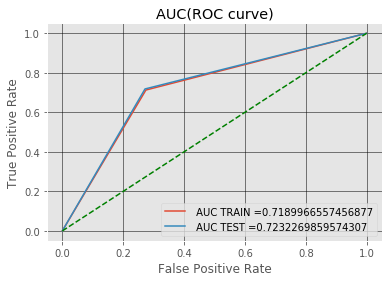

Wall time: 252 ms


,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.727362,0.735837,0.718859
1,1,0.722905,0.720740,0.725115
2,2,0.717143,0.725145,0.708939
3,3,0.719861,0.728612,0.711043
4,4,0.718556,0.721697,0.715484
5,5,0.722905,0.731638,0.714161
6,6,0.721383,0.724805,0.717954
7,7,0.717795,0.728597,0.707307
8,8,0.718665,0.723199,0.714224
9,9,0.720187,0.724755,0.715648


In [196]:
%%time
#Utilized code from https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

piped_object_svc = Pipeline([('scale', std_scl),  # do this
                         ('svm', svm_sgd)])


X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.20)


piped_object_svc.fit(X_train,y_train)

y_train_pred =piped_object_svc.predict(X_train)    
y_test_pred = piped_object_svc.predict(X_test) 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



final_sgd_results

### SVM Stochastic Descent Analysis
Applying a stochastic descent to our SVM model in an attempt to reduce the processing time as shown above did work to reduce the time siginifcantly. However we also see a drop in the accuracy, sensitivity and specificity back to similar levels in our base model at 72% average for each. Given the increases in accuracy were small improvements.Examining the ROC curve, we can assess our models' true-positive to false-positive tradeoff relationship.  The AUC for both the training and test set is basically identical at about 72%, which gives us confidence that our prediction model will preform well on other similar datasets.


<a id="WSVMSG"></a>
# Interpretation of Weights of SVM classifier with Stochastic descent

,Variable,Weight
4,PAY_0,0.503399
5,PAY_5,0.171169
7,BILL_AMT2,-0.003409
6,BILL_AMT1,-0.088876
9,PAY_AMT2,-0.138244
8,PAY_AMT1,-0.154596
0,LIMIT_BAL,-0.223981
2,EDUCATION,-0.267098
1,SEX,-0.333688
3,MARRIAGE,-0.409787


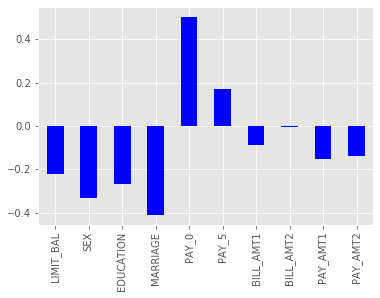

Wall time: 185 ms


In [43]:
%%time
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size=0.2, random_state=seed)

svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

piped_object_bsgd = Pipeline([('scale', std_scl),  # do this
                         ('svm', svm_sgd)])

piped_object_bsgd.fit(X_train,y_train)


svm_weights = svm_sgd.coef_.T # take transpose to make a column vector
variable_names = imp_col

Final_svm_sgd_weights =pd.DataFrame({'Variable':variable_names,'Weight': svm_weights.ravel()},columns=['Variable','Weight'])
Final_svm_sgd_weights.sort_values(by="Weight",inplace=True,ascending=False)


display(Final_svm_sgd_weights)


graph_weights = pd.Series(svm_sgd.coef_[0],index=variable_names)
graph_weights.plot(kind='bar',color='blue')
plt.show()

Examining the weights of attributes included in the SVM stochastic descent model we see that these weights are very similiar to the weights in the final logistic regression model. The only difference is that the weights are slightly smaller, therefore our interpetion of the SVM stochastic descent model's weights is the same as the logistric regression model.  


